In [15]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from sklearn.model_selection import train_test_split
from keras.layers import Dense, Flatten, LSTM, Conv1D, MaxPooling1D, Dropout, Activation, SpatialDropout1D
from keras.layers.embeddings import Embedding
from keras.callbacks import EarlyStopping

In [16]:
df = pd.read_csv('news.csv')
df.head()

text    label
0  Nhiều người cho rằng rượu vang đỏ nếu uống điề...  SucKhoe
1  Bây giờ mình có viết gì về lợi ích của giấc ng...  SucKhoe
2  Một nghiên cứu được công bố cách đây không lâu...  SucKhoe
3  Nhiều người cho rằng, uống nhiều rượu bia, hay...  SucKhoe
4  Giấc mơ thầm kín của kha khá anh em đó làm sao...  SucKhoe

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1476 entries, 0 to 1475
Data columns (total 2 columns):
text     1476 non-null object
label    1476 non-null object
dtypes: object(2)
memory usage: 23.1+ KB


In [18]:
df.label.value_counts()

QuangCaoKhuyenMai    250
TinTucCongNghe       250
XeMay                250
KhoaHoc              250
SucKhoe              250
DienAnh              226
Name: label, dtype: int64

In [19]:
def load_vi_stopwords(path):
    stopwords = []
    with open(path, 'r', encoding='utf8') as f:
        for line in f.readlines():
            stopwords.append(line.strip())
    
    return stopwords

In [20]:
REPLACE_BY_SPACE_RE=re.compile('[/(){}\[\]\|@,;]')
RE_HTML_TAG = re.compile(r'<[^>]+>')
STOPWORDS = load_vi_stopwords("./stopwords.txt")

def clean_text(text):
    text = text.lower()
    text = RE_HTML_TAG.sub(' ', text)
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
    text = text.replace('x', '')
    text = ' '.join(word for word in text.split() if word not in STOPWORDS)
    return text

In [21]:
df['text'] = df['text'].apply(clean_text)

In [22]:
MAX_NB_WORDS = 50000
MAX_SEQUENCE_LENGTH = 250
EMBEDDING_DIM = 100

tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df['text'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 19866 unique tokens.


In [23]:
X = tokenizer.texts_to_sequences(df['text'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)                     

Y = pd.get_dummies(df['label'].values)
print('Shape of label tensor:', Y.shape)

Shape of data tensor: (1476, 250)
Shape of label tensor: (1476, 6)


In [24]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.1, random_state = 42)
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

(1328, 250) (1328, 6)
(148, 250) (148, 6)


In [25]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.1))
model.add(LSTM(100, dropout=0.1, recurrent_dropout=0.15))
model.add(Dense(6, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']) 

In [26]:
epochs = 20
batch_size = 64

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Train on 1195 samples, validate on 133 samples
Epoch 1/20
1195/1195 [==============================] - 8s 6ms/step - loss: 1.7796 - acc: 0.2544 - val_loss: 1.7581 - val_acc: 0.3383
Epoch 2/20
1195/1195 [==============================] - 6s 5ms/step - loss: 1.5779 - acc: 0.4427 - val_loss: 1.4893 - val_acc: 0.4436
Epoch 3/20
1195/1195 [==============================] - 7s 6ms/step - loss: 1.3027 - acc: 0.5582 - val_loss: 1.2109 - val_acc: 0.5789
Epoch 4/20
1195/1195 [==============================] - 7s 6ms/step - loss: 1.0867 - acc: 0.6192 - val_loss: 1.1229 - val_acc: 0.6015
Epoch 5/20
1195/1195 [==============================] - 7s 6ms/step - loss: 0.8676 - acc: 0.6669 - val_loss: 0.8559 - val_acc: 0.6617
Epoch 6/20
1195/1195 [==============================] - 7s 6ms/step - loss: 0.6972 - acc: 0.7372 - val_loss: 0.8505 - val_acc: 0.6316
Epoch 7/20
1195/1195 [==============================] - 8s 6ms/step - loss: 0.5946 - acc: 0.7891 - val_loss: 0.7789 - val_acc: 0.7143
Epoch 8/20
1195

In [27]:
accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

148/148 [==============================] - 0s 2ms/step
Test set
  Loss: 0.689
  Accuracy: 0.750


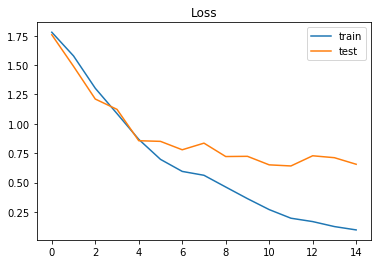

In [28]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

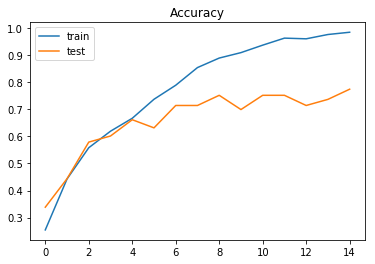

In [29]:
plt.title('Accuracy')
plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='test')
plt.legend()
plt.show();